# UncertainTaggerBuilderTest

Ad-hoc testing for the UncertainTaggerBuilder class.

In [1]:
import os
import pickle
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from MotifFeatures.UncertainTaggerBuilder import UncertainTaggerBuilder
from MotifFeatures.Labels.BIOELabel import BIOELabel

In [2]:
train_path = os.path.join('datasets', 'occ_45K_train.pickle')
with open(train_path, 'rb') as dbfile:
    train = pickle.load(dbfile)
motifs_path = os.path.join(
    'MotifFeatures', 'MotifGopher',
    'Gopher_01-49PM_21_Mar_2021_motifs.pickle')
with open(motifs_path, 'rb') as dbfile:
    motifs = pickle.load(dbfile)

In [3]:
def tag_matrix(dataset, textgetter, entitygetter):
    """Return a four-column dataframe of the BIOELabel output for
    matches to the entity returned by entitygetter.
    """
    data = {tag: [] for tag in ('raw', 'B', 'I', 'O', 'E')}
    def process(row):
        data['raw'].append(textgetter(row))
        for tag, value in BIOELabel(
                textgetter(row), entitygetter(row)).tags().items():
            data[tag].append(value)
    dataset.apply(process, axis=1)
    return pd.DataFrame(data)
author_tags_path = os.path.join('datasets', 'author_tags_scratch.pickle')
if not os.path.exists(author_tags_path):
    t0 = time.time()
    author_tags = tag_matrix(
        train, lambda row: row.raw, lambda row: row.author.surnames()
    )
    print('Author tags generated in {:.2f} seconds.'.format(
        time.time() - t0))
    with open(author_tags_path, 'ab') as dbfile:
        pickle.dump(author_tags, dbfile, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(author_tags_path, 'rb') as dbfile:
        author_tags = pickle.load(dbfile)
author_tags.head()

,raw,B,I,O,E
0,"Knechtle, B, Knechtle, P, Schulze, I, Kohler, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Sousa, M, Fernandes, MJ, Moreira, P, Teixeira,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,"Schooler, J. (2011). Unpublished results hide ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,"Melin, A, Tornberg, AB, Skouby, S, Moller, SS,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,"Schenk, K, Faulhaber, M, Gatterer, H, Burtsche...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [5]:
sample = author_tags.sample(1000)
t0 = time.time()
utb = UncertainTaggerBuilder(
    texts=sample.raw, tags=sample.B, motifs=motifs, sort_sample_size=100)
print('Time to initialize:', time.time() - t0)

NameError: name 'n' is not defined

In [10]:
utb.improve()

TypeError: 'method' object is not iterable

In [15]:
type(list(utb._states.keys())

list

In [ ]:
utb.improve()

In [6]:
for featureset in utb._states:
    print(utb._states[featureset].oob_score, utb._states[featureset].cv_score)

0.26510773187279346 (0.402335900541211, 0.40256882149915657)
0.19819044800079322 (nan, nan)
0.07999646632752189 (nan, nan)
0.11327987396502193 (0.021195492638121156, 0.022713442004527497)
0.22461335926410642 (nan, nan)
0.5650789219691059 (0.6222504459320146, 0.6230137812418679)
0.43627532970620764 (0.4666241591735091, 0.46829339465235476)
0.4358428132614023 (0.4660184105484766, 0.4676473655844936)
0.5642444568586058 (0.6201208036592976, 0.6207578351395246)
0.2187618538570537 (nan, nan)
0.24934546205953845 (0.010218200074972907, 0.011043197014926232)
0.22461335926410642 (nan, nan)
0.11327987396502193 (0.010218200074972907, 0.011043197014926232)
0.2405913172333075 (0.016385663345129316, 0.016995691461710358)
0.24899730631908457 (0.04919110865041069, 0.050477691711668195)
0.5658429706335987 (0.6201035423458765, 0.620937651358767)
0.5653842049500402 (0.6197433716929419, 0.6205361979056998)
0.5642132688059753 (0.6201208036592976, 0.6207578351395246)
0.4358444264007031 (0.4650557680078522, 0

In [7]:
len(utb._states)

31

In [24]:
for f in utb._states:
    if utb._states[f].oob_score > 0.5:
        print(len(f), end=': ')
        print([str(el) if hasattr(el, '_motif') else 'p?' for el in f], end=' => ')
        print(utb._states[f].mean_cv())

2: ['-1th_", "', 'p?'] => 0.6226321135869413
2: ['0th_", "', 'p?'] => 0.6204393193994111
3: ['-1th_", "', '-1th_" "', 'p?'] => 0.6205205968523217
3: ['-1th_", "', '0th_" "', 'p?'] => 0.6201397847993209
3: ['0th_", "', '-1th_", "', 'p?'] => 0.6204393193994111
3: ['0th_", "', '-1th_" "', 'p?'] => 0.6186201606430113
3: ['0th_", "', '0th_" "', 'p?'] => 0.6181642390672507
4: ['-1th_", "', '0th_" "', '-1th_" "', 'p?'] => 0.6199599871477911
4: ['0th_", "', '-1th_", "', '-1th_" "', 'p?'] => 0.6179021677758658
4: ['0th_", "', '-1th_", "', '0th_" "', 'p?'] => 0.6168508667161314
4: ['0th_", "', '0th_" "', '-1th_" "', 'p?'] => 0.6170933294308887
5: ['0th_", "', '0th_" "', 'p?', '-1th_", "', '-1th_" "'] => 0.6163652478685634


In [18]:
for f in utb._features[:45]:
    try:
        print(str(f))
    except:
        print(repr(f))
        pass

-1th_", "
-1th_" "
0th_" "
0th_", "
0th_". "
0th_"r"
0th_"a"
0th_"e"
0th_"."
0th_"i"
0th_"s"
0th_"t"
0th_"n"
0th_"o"
0th_"2"
0th_"c"
0th_"1"
0th_"u"
0th_"d"
-1th_"e"
0th_"l"
0th_"m"
0th_"n "
0th_": "
0th_"s "
0th_"0"
-1th_"a"
0th_"in"
0th_"h"
0th_" a"
0th_"ID: "
0th_"f"
0th_"ti"
0th_"3"
0th_"D: "
-1th_" H"
0th_"6"
0th_"y"
-1th_"M, "
0th_"e "
0th_"MID: "
0th_" P"
0th_"9"


In [5]:
import scipy
utb._CV(utb._features[:5], k=5, confidence=0.9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   11.5s finished
DEBUG: pred:  [0.82 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.
 0.   0.   0.18 0.   0.   0.01]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
DEBUG: precision:  0.7143437132069343
DEBUG: recall:  0.7024793388429752
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.1min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_job

(0.7076130676909922, 0.7078092812415084)

In [6]:
utb._CV(utb._features[:15], k=5, confidence=0.9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   13.3s finished
DEBUG: pred:  [0.89 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.97 0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
DEBUG: precision:  0.9061658129387213
DEBUG: recall:  0.9567725652017147
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.5min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_job

(0.9314494071872645, 0.9317887091104284)

In [7]:
utb._CV(utb._features[:30], k=5, confidence=0.9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 49.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.5s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   14.4s finished
DEBUG: pred:  [0.82 0.   0.01 0.01 0.   0.   0.   0.   0.   0.92 0.   0.   0.   0.
 0.   0.   0.01 0.   0.   0.86]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
DEBUG: precision:  0.9153475567790778
DEBUG: recall:  0.957753240518483
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 47.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs

(0.9344782094887113, 0.9346239206612587)

In [8]:
utb._CV(utb._features[:60], k=5, confidence=0.9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 51.6min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   23.5s finished
DEBUG: pred:  [0.87 0.   0.   0.   0.   0.   0.   0.   0.   0.06 0.   0.   0.91 0.
 0.01 0.   0.   0.   0.01 0.  ]
DEBUG: actual:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
DEBUG: precision:  0.913816425120773
DEBUG: recall:  0.949140976236352


KeyboardInterrupt: 

In [6]:
[str(feature) for feature in utb._features[:10]]

['-1th_", "',
 '0th_", "',
 '0th_" "',
 '0th_". "',
 '-1th_"J, "',
 '-1th_" "',
 '-1th_"H, "',
 '-1th_" S"',
 '-1th_" K"',
 '-1th_" W"']

In [5]:
X, y = utb._X(), utb._labels()

In [26]:
regr = RandomForestRegressor(
    random_state=0, verbose=1, n_jobs=-1)

In [27]:
t0 = time.time()
regr.fit(X, y)
print('Elapsed time:', time.time() - t0)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  4.8min
Elapsed time: 593.4815990924835
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  9.9min finished


In [30]:
[
    X.columns[idx] + ' -> ' + str(regr.feature_importances_[idx])
    for idx in range(len(X.columns))
    if regr.feature_importances_[idx] > 0.0014
]

['-1th_"i" -> 0.03139330469785673',
 '-1th_" " -> 0.030653403690900877',
 '-1th_"r" -> 0.002516241148017014',
 '-1th_"e" -> 0.05082396238975671',
 '-1th_"n" -> 0.004698896506257944',
 '-1th_"a" -> 0.04924226826706511',
 '-1th_"t" -> 0.00352795080863393',
 '-1th_"s" -> 0.005556928071292358',
 '-1th_"o" -> 0.03615993932352817',
 '-1th_". " -> 0.031609844380332396',
 '-1th_"." -> 0.0015290126610194186',
 '-1th_", " -> 0.1252682644062291',
 '-1th_"u" -> 0.015811471513609097',
 '-1th_"h" -> 0.0062621085694191',
 '-1th_"m" -> 0.0014475392387895741',
 '-1th_"M" -> 0.0024070756119629966',
 '-1th_"e " -> 0.005769372641047589',
 '-1th_"y" -> 0.005068830645877607',
 '-1th_"S" -> 0.004563153390237448',
 '-1th_"A" -> 0.0026830181413667734',
 '-1th_"C" -> 0.002325269359642735',
 '-1th_"J" -> 0.003336292566078514',
 '0th_"i" -> 0.025638028692881412',
 '0th_" " -> 0.08368215974583824',
 '0th_"r" -> 0.014615038521526562',
 '0th_"e" -> 0.02441914534215503',
 '0th_"n" -> 0.002964311322686968',
 '0th_"a" 

(array([133.,  30.,   7.,   4.,   5.,   1.,   1.,   0.,   1.,   1.,   1.,
          3.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   0.,   0.,   1.,
          2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.00140581, 0.00281162, 0.00421743, 0.00562323,
        0.00702904, 0.00843485, 0.00984066, 0.01124647, 0.01265228,
        0.01405808, 0.01546389, 0.0168697 , 0.01827551, 0.01968132,
        0.02108713, 0.02249293, 0.02389874, 0.02530455, 0.02671036,
        0.02811617, 0.02952198, 0.03092778, 0.

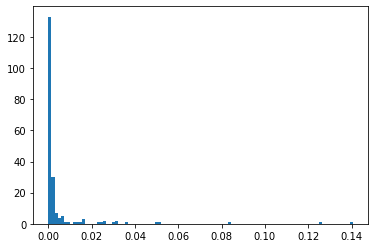

In [28]:
plt.hist(regr.feature_importances_, bins=100)

(array([ 92., 395., 113.,  69.,  57.,  30.,  30.,  19.,  16.,  28.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

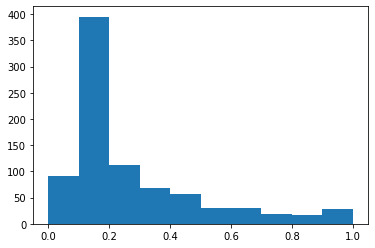

In [37]:
import random
frequencies = set()
sample_raws = set(author_tags.raw)
for motif in motifs:
    frequencies.add(
        sum(1 if motif in text else 0 for text in sample_raws)
        / len(sample_raws))
plt.hist(frequencies)

In [38]:
len(sample_raws)

33292